In [3]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
from jax import jit, lax, grad
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib


import gpytorch
import torch
import linear_operator
from linear_operator.operators import (
    AddedDiagLinearOperator,
    DiagLinearOperator,
    LinearOperator,
    DenseLinearOperator,
)

from jax.config import config
config.update("jax_enable_x64", True)

/home/ogawa_kenta/.conda/envs/mytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
## import modules
import preconditioner as precond
import conjugate_gradient as cg
import pivoted_cholesky as pc
import pivoted_cholesky_ref as pc_ref # to use this script we need "torch", please comment out if not needed.
import calc_logdet
import calc_trace
def reload():
    importlib.reload(precond)
    importlib.reload(cg)
    importlib.reload(pc)
    importlib.reload(pc_ref)
    importlib.reload(calc_logdet)
    importlib.reload(calc_trace)
reload()

In [5]:
import warnings
warnings.filterwarnings("always")

In [6]:
from stopro.data_generator.sinusoidal import Sinusoidal
from stopro.data_preparer.data_preparer import DataPreparer
from stopro.sub_modules.load_modules import load_params, load_data
from stopro.sub_modules.loss_modules import hessian, logposterior
from stopro.sub_modules.init_modules import get_init, reshape_init
import stopro.GP.gp_sinusoidal_independent as gp_sinusoidal_independent
from stopro.GP.kernels import define_kernel
# from stopro.solver.optimizers import optimize_by_adam
from stopro.data_handler.data_handle_module import *

In [7]:
def is_positive_definite(matrix):
    # 行列の固有値を計算
    eigenvalues = np.linalg.eigvals(matrix)

    # 全ての固有値が正であるかをチェック
    if np.all(eigenvalues > 0):
        return True
    else:
        return False

In [75]:
def rel_error(true, pred):
    true_max = np.max(true)
    zero_threshold = (
        true_max * 1e-7
    )  # ignore the data that test value is smaller than 1e-7
    index = np.where(abs(true) > zero_threshold)
    if np.all(abs(true) <= zero_threshold):
        rel_error = 0.0
        return rel_error
    true2 = true[index]
    pred2 = pred[index]
    rel_error = np.abs((true2 - pred2) / true2)
    # print(rel_error)
    return rel_error

In [8]:
project_name = 'test'
simulation_name = 'data'

In [9]:
params_main, params_prepare, lbls = load_params(f"{project_name}/{simulation_name}/data_input")
params_model = params_main["model"]
params_optimization = params_main["optimization"]
params_plot = params_prepare["plot"]
vnames = params_prepare["vnames"]
params_setting = params_prepare["setting"]
params_generate_training = params_prepare["generate_training"]
params_generate_test = params_prepare["generate_test"]
params_kernel_arg = params_prepare["kernel_arg"]

# prepare initial hyper-parameter
init = get_init(
    params_model["init_kernel_hyperparameter"],
    params_model["kernel_type"],
    system_type=params_model["system_type"],
)

In [10]:
# prepare data
hdf_operator = HdfOperator(f"{project_name}/{simulation_name}")
r_test, μ_test, r_train, μ_train, f_train = load_data(lbls, vnames, hdf_operator)
delta_y_train = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train = jnp.append(delta_y_train, f_train[i] - μ_train[i])

args_predict = r_test, μ_test, r_train, delta_y_train, params_model["epsilon"]

In [11]:
# setup model
Kernel = define_kernel(params_model)
gp_model = gp_sinusoidal_independent.GPSinusoidalWithoutPIndependent(
    use_difp=params_setting["use_difp"],
    use_difu=params_setting["use_difu"],
    lbox=jnp.array([2.5, 0.0]),
    infer_governing_eqs=params_prepare["generate_test"]["infer_governing_eqs"],
    Kernel=Kernel,
    index_optimize_noise=params_model["index_optimize_noise"],
)
gp_model.set_constants(*args_predict)

## check K^{-1}y with precondition

In [12]:
scale = 0.
length = 0.
noise = 1e-06
init = jnp.array([scale, length, length, scale, length, length, scale, length, length])

In [12]:
K = gp_model.trainingK_all(init, r_train)
K_torch = torch.from_numpy(np.array(K))
K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

In [15]:
is_positive_definite(K), jnp.linalg.cond(K)

(True, DeviceArray(1.14976524e+09, dtype=float64))

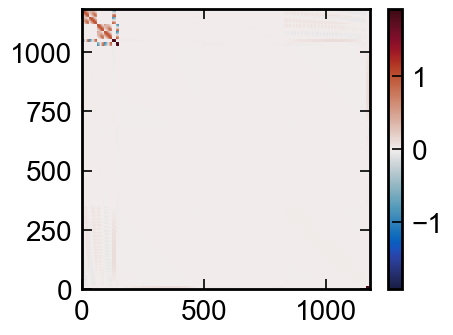

In [55]:
fig, ax = plt.subplots(figsize=(5, 4))
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [56]:
rank_list = [0, 5, 10, 20, 40, 80, 160, 320]

In [57]:
converge_iteration_list = []
for rank in rank_list:
    precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, min_preconditioning_size=2)
    Kinvy, j = cg.mpcg_bbmm(K, rhs[:, -1], precondition=precondition, print_process=False, tolerance=0.01, max_iter_cg=10000, n_tridiag=0)
    converge_iteration_list.append(j)

In [16]:
rank=5
n_tridiag = 10
zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y_train), n_tridiag))
rhs = jnp.concatenate([zs, delta_y_train.reshape(-1, 1)], axis=1)

In [124]:
%%timeit
# no preconditoin
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank)
Kinvy, j = cg.mpcg_bbmm(K, rhs[:, -1], precondition=precondition, print_process=False, tolerance=0.01, max_iter_cg=10000, n_tridiag=0)

917 ms ± 5.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
%%timeit
# no preconditoin with rank 5
rank=5
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, min_preconditioning_size=1)
Kinvy, j = cg.mpcg_bbmm(K, rhs[:, -1], precondition=precondition, print_process=False, tolerance=0.01, max_iter_cg=10000, n_tridiag=0)

1.42 s ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
%%timeit
# no preconditoin with rank 10
rank=10
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, min_preconditioning_size=1)
Kinvy, j = cg.mpcg_bbmm(K, rhs[:, -1], precondition=precondition, print_process=False, tolerance=0.01, max_iter_cg=10000, n_tridiag=0)

1.2 s ± 6.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
%%timeit
# no preconditoin with rank 20
rank=20
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, min_preconditioning_size=1)
Kinvy, j = cg.mpcg_bbmm(K, rhs[:, -1], precondition=precondition, print_process=False, tolerance=0.01, max_iter_cg=10000, n_tridiag=0)

943 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
%%timeit
# no preconditoin with rank 40
rank=40
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, min_preconditioning_size=1)
Kinvy, j = cg.mpcg_bbmm(K, rhs[:, -1], precondition=precondition, print_process=False, tolerance=0.01, max_iter_cg=10000, n_tridiag=0)

437 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
%%timeit
# no preconditoin with rank 40
rank=80
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, min_preconditioning_size=1)
Kinvy, j = cg.mpcg_bbmm(K, rhs[:, -1], precondition=precondition, print_process=False, tolerance=0.01, max_iter_cg=10000, n_tridiag=0)

348 ms ± 9.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%%timeit
# no preconditoin with rank 160
rank=160
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, min_preconditioning_size=1)
Kinvy, j = cg.mpcg_bbmm(K, rhs[:, -1], precondition=precondition, print_process=False, tolerance=0.01, max_iter_cg=10000, n_tridiag=0)

421 ms ± 7.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [97]:
%%timeit
# no preconditoin with rank 160
rank=320
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, min_preconditioning_size=1)
Kinvy, j = cg.mpcg_bbmm(K, rhs[:, -1], precondition=precondition, print_process=False, tolerance=0.01, max_iter_cg=10000, n_tridiag=0)

438 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [128]:
convergence_time = [0.917, 1.42, 1.2, 0.943, 0.437, 0.348, 0.421, 0.438]

In [129]:
converge_iteration_list

[2471, 3677, 2932, 1869, 656, 86, 21, 21]

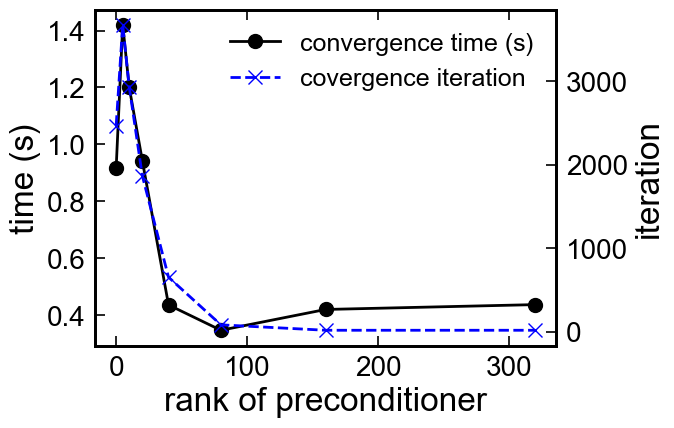

In [133]:
fig, ax = plt.subplots()
ax.plot(rank_list, convergence_time, label='convergence time (s)', marker='o', linestyle='-')
ax2 = ax.twinx()
ax2.plot(rank_list, converge_iteration_list, color='b', linestyle='--', label='covergence iteration', marker='x')
ax.set_xlabel('rank of preconditioner')
ax.set_ylabel('time (s)')
ax2.set_ylabel('iteration')
# Get lines and labels for both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Create a legend for the first line in each axes
ax.legend(lines + lines2, labels + labels2, loc='best')

In [134]:
# Kinvy_linalg = jnp.linalg.solve(K, delta_y_train)
L = jnp.linalg.cholesky(K)
v = jnp.linalg.solve(L, delta_y_train)
Kinvy_cholesky = jnp.linalg.solve(L.T, v)

In [55]:
rhs_torch = torch.from_numpy(np.array(rhs))
K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(len(delta_y_train), dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)
linear_operator.settings.cg_tolerance._set_value(0.01)

In [56]:
Kinvy_torch = added_diag._solve(rhs_torch[:, -1:], preconditioner=None, num_tridiag=0, )

/home/ogawa_kenta/.conda/envs/mytorch/lib/python3.9/site-packages/linear_operator/utils/linear_cg.py:323: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.9042190600007949 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


In [118]:
yKy_linalg = delta_y_train@Kinvy_cholesky
yKy = delta_y_train@Kinvy
yKy_torch = delta_y_train@Kinvy_torch.numpy()

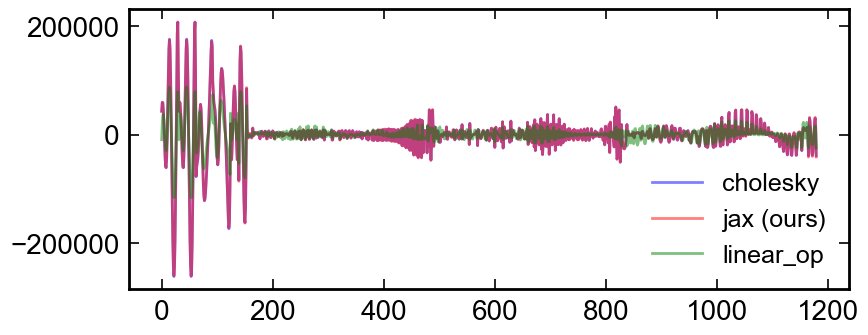

In [119]:
alpha = 0.5
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Kinvy_cholesky, color='b', alpha=alpha, label='cholesky')
ax.plot(Kinvy, color='r', alpha=alpha, label='jax (ours)')
ax.plot(Kinvy_torch, color='g', alpha=alpha, label='linear_op')
plt.legend()

## check convergence

In [59]:
cov_scale = 0.
length = 2.3
init = jnp.array([cov_scale, length, length, cov_scale, length, length, cov_scale, length, length])

In [60]:
### scale data ###
scale = 10
r_train_scaled = [_r * scale for _r in r_train]
r_test_scaled = [_r * scale for _r in r_test]
# delta_y_train_scaled = delta_y_train.copy()
# delta_y_train_scaled[4] = delta_y_train_scaled[4] / scale**2
delta_y_train_scaled = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train_scaled = jnp.append(
        delta_y_train_scaled, f_train[i] / scale**2 - μ_train[i]
    )
print(delta_y_train_scaled)

[0. 0. 0. ... 0. 0. 0.]


In [61]:
gp_model = gp_sinusoidal_independent.GPSinusoidalWithoutPIndependent(
    use_difp=params_setting["use_difp"],
    use_difu=params_setting["use_difu"],
    lbox=jnp.array([2.5*scale, 0.0]),
    infer_governing_eqs=params_prepare["generate_test"]["infer_governing_eqs"],
    Kernel=Kernel,
    index_optimize_noise=params_model["index_optimize_noise"],
)
gp_model.set_constants(*args_predict)

In [62]:
K = gp_model.trainingK_all(init, r_train_scaled)
K_torch = torch.from_numpy(np.array(K))
K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

In [63]:
rank=5
n_tridiag = 10
zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y_train_scaled), n_tridiag))
rhs = jnp.concatenate([zs, delta_y_train_scaled.reshape(-1, 1)], axis=1)

In [85]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, min_preconditioning_size=2000)
Kinvy, j, t_mat = cg.mpcg_bbmm(K, rhs, precondition=precondition, print_process=False, tolerance=0.01, max_iter_cg=5000, n_tridiag=n_tridiag)

In [86]:
j

1443

In [87]:
# Kinvy_linalg = jnp.linalg.solve(K, delta_y_train)
L = jnp.linalg.cholesky(K)
v = jnp.linalg.solve(L, delta_y_train_scaled)
Kinvy_cholesky = jnp.linalg.solve(L.T, v)

In [88]:
jnp.mean(rel_error(Kinvy_cholesky, Kinvy[:, -1]))

DeviceArray(0.00287278, dtype=float64)

## checking log determinant and trace term (without precondition)

In [248]:
rank= 400
n_tridiag = 250
zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y_train_scaled), n_tridiag))
rhs = jnp.concatenate([zs, delta_y_train_scaled.reshape(-1, 1)], axis=1)

In [249]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, min_preconditioning_size=1)
Kinvy, j, t_mat = cg.mpcg_bbmm(K, rhs, precondition=precondition, print_process=False, tolerance=0.0001, max_iter_cg=5000, n_tridiag=n_tridiag)

In [250]:
j

20

In [251]:
# Kinvy_linalg = jnp.linalg.solve(K, delta_y_train)
L = jnp.linalg.cholesky(K)
v = jnp.linalg.solve(L, delta_y_train_scaled)
Kinvy_cholesky = jnp.linalg.solve(L.T, v)

In [252]:
jnp.mean(rel_error(Kinvy_cholesky, Kinvy[:, -1]))

DeviceArray(8.06779276e-07, dtype=float64)

In [253]:
logdet = calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache)

In [254]:
logdet

DeviceArray(-15686.09077905, dtype=float64)

In [255]:
def logdet_linalg(K):
    L = jnp.linalg.cholesky(K)
    return jnp.sum(jnp.log(jnp.diag(L)))*2

In [256]:
logdet_linalg(K)

DeviceArray(-15425.21428544, dtype=float64)

In [203]:
# Kinvy_linalg = jnp.linalg.solve(K, delta_y_train)
L = jnp.linalg.cholesky(K)
v = jnp.linalg.solve(L, delta_y_train_scaled)
Kinvy_cholesky = jnp.linalg.solve(L.T, v)

In [175]:
linear_operator.settings.max_cg_iterations._set_value(10000)
linear_operator.settings.max_lanczos_quadrature_iterations._set_value(20)

In [176]:
rhs_torch = torch.from_numpy(np.array(rhs))
K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(len(delta_y_train), dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)
linear_operator.settings.cg_tolerance._set_value(0.01)

In [177]:
Kinvy_torch, t_mat = added_diag._solve(rhs_torch, preconditioner=None, num_tridiag=n_tridiag)

In [178]:
added_diag.inv_quad_logdet(inv_quad_rhs=rhs_torch[:, :-1], logdet=True)

(tensor(2.1092e+10, dtype=torch.float64),
 tensor(-10456.8284, dtype=torch.float64))

In [159]:
preconditioner_torch, _, _ = added_diag._preconditioner()

In [160]:
Kinvy_torch, t_mat = added_diag._solve(rhs_torch, preconditioner=preconditioner_torch, num_tridiag=n_tridiag)

In [161]:
added_diag.inv_quad_logdet(inv_quad_rhs=rhs_torch[:, :-1], logdet=True)

(tensor(1.0590e+10, dtype=torch.float64),
 tensor(-12702.8055, dtype=torch.float64))

In [453]:
yKy_linalg = delta_y_train_scaled@Kinvy_cholesky
yKy = delta_y_train_scaled@Kinvy[:, -1]
yKy_torch = delta_y_train_scaled@Kinvy_torch[:, -1].numpy()

In [454]:
(yKy_linalg-yKy)/yKy_linalg, (yKy_linalg-yKy_torch)/yKy_linalg

(DeviceArray(1.05516333e-07, dtype=float64),
 DeviceArray(0.99480404, dtype=float64))

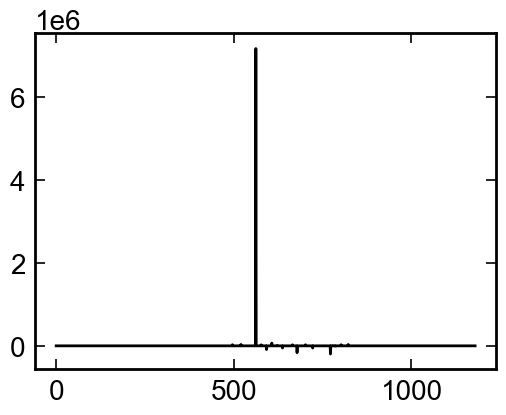

In [467]:
plt.plot((Kinvy[:, -1] - Kinvy_cholesky) / Kinvy_cholesky)

In [471]:
jnp.sort(jnp.abs(Kinvy_cholesky))[:10]

DeviceArray([3.85225487e-09, 6.98533029e-08, 1.06716759e-07,
             1.58446495e-07, 1.98210508e-07, 2.08917213e-07,
             3.43760917e-07, 5.80299882e-07, 6.11637239e-07,
             6.36148365e-07], dtype=float64)

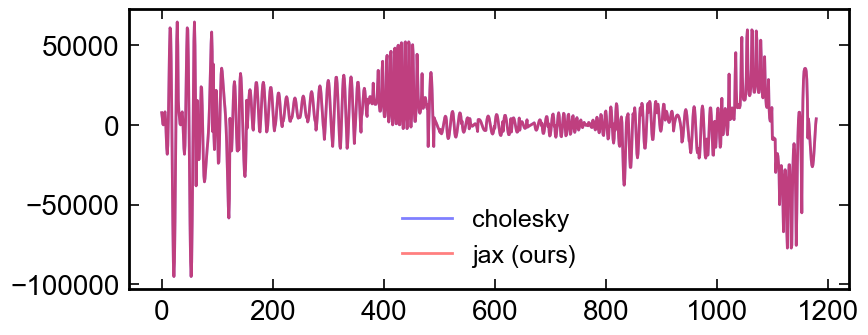

In [89]:
alpha = 0.5
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Kinvy_cholesky, color='b', alpha=alpha, label='cholesky')
ax.plot(Kinvy[:, -1], color='r', alpha=alpha, label='jax (ours)')
# ax.plot(Kinvy_torch, color='g', alpha=alpha, label='linear_op')
plt.legend()

## trace term

In [257]:
noise

1e-06

In [258]:
def calc_trainingK(theta):
    θ, noise = gp_model.split_hyp_and_noise(theta)
    Σ = gp_model.trainingK_all(θ, r_train_scaled)
    noise = 1e-06
    Σ = gp_model.add_eps_to_sigma(Σ, noise, noise_parameter=None)
    return Σ

In [259]:
dKdtheta = jnp.transpose(jax.jacfwd(calc_trainingK)(init), (2, 0, 1))

In [260]:
calc_trace.calc_trace(Kinvy, dKdtheta[6], zs, n_tridiag=n_tridiag)

DeviceArray(35.88469096, dtype=float64)

In [261]:
Kinv_linalg = jnp.linalg.inv(K)
trace_linalg = jnp.sum(jnp.diag(jnp.matmul(Kinv_linalg, dKdtheta[6])))
trace_linalg

DeviceArray(36.30927405, dtype=float64)

In [262]:
I = jnp.eye(len(delta_y_train))
Kinv = jnp.linalg.solve(L.T, jnp.linalg.solve(L, I))
trace_linalg = jnp.sum(jnp.diag(jnp.matmul(Kinv, dKdtheta[6])))
trace_linalg

DeviceArray(36.30927405, dtype=float64)